# Code examples used in chapter 5 on recurrent neural networks

In [2]:
# Display plots inline and change default figure size
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from sklearn.neural_network import MLPRegressor
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Illustration of feed-forward neural network for time-series modeling
We create a nonlinear function of $T$ data points using the sin function. That is: $y(x_t)=sin(0.01 \cdot x_t)+0.02*\epsilon$ with $\epsilon \in \mathcal{N} \left( 0,1 \right )$. 

Please note that this example is re-implemented based on http://d2l.ai/chapter_recurrent-neural-networks/sequence.html.


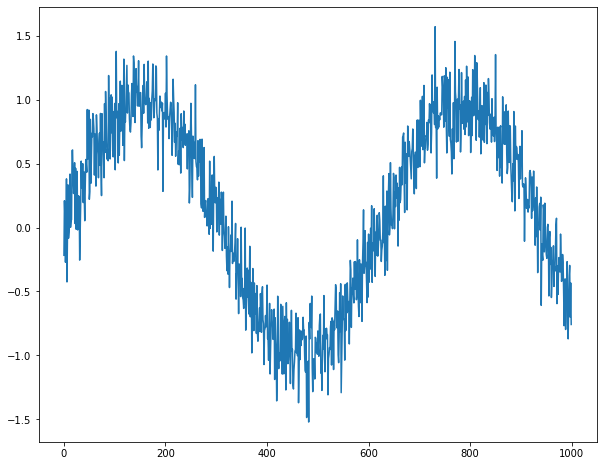

In [3]:
T = 1000  # Generate a total of 1000 points
time = np.arange(0,T)
np.random.seed(123)
x = np.sin(0.01 * time) + 0.2 * np.random.normal(size=T)
plt.plot(time, x);

To predict the next observation in the sequence, $x_{t+1}$, we need some input features. As discussed in the lecture, it is common practice to obtain these features through using a set of previous observations $x_t, x_{t-1}, ... x_{t-\tau}$. This gives an auto-regressive model of the form: $x_{t+1} = f \left (x_t, x_{t-1}, ... x_{t-\tau} \right )$, whereby the parameter $\tau$ governs the number of past observations to be considered. 

In [5]:
tau = 4  # Embedding dimension for autoregressive model
features = np.zeros((T-tau, tau))
for i in range(tau):
    features[:,i] = x[i:T-tau+i]
labels = x[tau:]

Have a look at the data and examine its organization. The pattern is bit difficult to interpret. What you see in the matrix is an organization of the form:
$x_{t+1}, x_{t-3}, x_{t-2}, x_{t-1}, x_{t}$. Follow this pattern across the rows and note how the target variable (i.e., first element in each row) becomes the last element, $x_{t}$, in the next row.

In [6]:
# Sketch data
tmp = np.concatenate((labels.reshape(labels.shape[0], 1) , features), axis=1)
tmp[0:5]

array([[-0.07573072, -0.21712612,  0.20946892,  0.07659437, -0.27126344],
       [ 0.38026648,  0.20946892,  0.07659437, -0.27126344, -0.07573072],
       [-0.42537184,  0.07659437, -0.27126344, -0.07573072,  0.38026648],
       [-0.01583968, -0.27126344, -0.07573072,  0.38026648, -0.42537184],
       [ 0.33310195, -0.07573072,  0.38026648, -0.42537184, -0.01583968]])

Next we create a training set of $ntrain$ data points, fit a neural network model to the training data, and subsequently let the trained network produce predictions for the full input data set (including the training data). 

In [11]:
ntrain = 600
ix_train = range(ntrain) 
ix_test = range(ntrain, (T-tau))
nn = MLPRegressor(random_state=123)
nn.fit(features[ix_train,:], labels[ix_train])
yhat_all = nn.predict(features)

# check MSE
mse = lambda y, yhat: np.sum((y-yhat)**2)/len(y)
print('MSE on training  is {:.4f}'.format(mse(labels[ix_train], yhat_all[ix_train])))
print('MSE on test  is {:.4f}'.format(mse(labels[ix_test], yhat_all[ix_test])))

To further examine the degree to which predictions agree with actual labels, we plot the data and the network predicted forecasts.

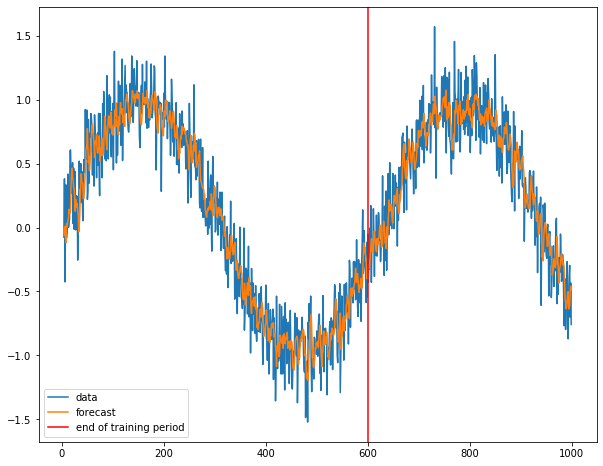

In [16]:
plt.plot(time[tau:], x[tau:], label='data');
plt.plot(time[tau:], yhat_all, label='forecast');
plt.axvline(x=ntrain, color='red', label='end of training period');
plt.legend();
plt.show();

The 'forecasts' look quite accurate, which agrees with the MSE. However, we have set our powerful neural network a relatively easy task. 
First, the first 600 predictions are calculated in-sample. The network has seen corresponding
data during training. Second, once we reach the out-of-sample data, from observation point 600
onwards, we present the network the actual input data. In other words, when our network predicts the value of 
the time series $x_{t+1}$, we assume that the prediction is - or can be - based on the 
__actual__ data $x_{t}, x_{t-1}, x_{t-2}, ..., x_{t-\tau} $. The first feature is most interesting.
Using $x_t$, the actual time series value at time point $t$, implies that this value has actually been observed. 
It is worthwhile to reason what this means. Considering, for example, the task of predicting the closing price of a stock 
at a day $t+1$, using $x_t$ among the input features means that the price of that stock at day $t$ must be known. 
So, if today were day $t$ and we want to predict the price of , e.g., SAP tomorrow, our network could produce a forecast 
once today's closing price of SAP is announced; not earlier. In general, it will depend on the application setting whether
using $x_t$ is feasible. In the stock prediction example, this is the case in that availability of a forecast of 
$x_{t+1}$ in the night of day $t$, recall that we could not produce the forecast earlier, would leave us enough time to
invest in the stock. Other application settings might prohibit using the most recent data point as model input.
For example, if we were interested in using our model not only to forecast observation point $t+1$ but also  
$t+2, t+3, ...t+m$, that is if we want to extend the forecasting horizon, we would need to use the forecasts of our model as input. 
For example, letting $nn\left(x_t\right)$ denote the neural network forecast for observation point $x_{t+1}$, the input
features for the network when predicting $x{t+2}$ would be:
$nn\left(x_t\right), x_{t-1},x_{t-2}, ..., x_{t-\tau}$. This setting facilitates forecasting two observation points ahead. 
Notice how we will very soon need to base our forecast only on forecasts of earlier time points when further extending
the forecasting horizon. To demonstrate this, let us use the neural network to forecast all data points in the test set 
(i.e., from observation point 600 till 999 in the current example). 

In [38]:
# Create an array of zeros to store the forecasts
predictions = np.zeros_like(yhat_all) 
# For the training set period, we can simply copy the forecasts
# from the previous example. Data of the training set is known by definition.
# Hence, no need to worry about availability of input data when using
# the model for forecasting
predictions[:(ntrain-tau)] = yhat_all[:(ntrain-tau)]
# Loop over the test set period and gather model inputs by looking at the past tau data points,
# which correspond to earlier model forecasts 
for i in range(ntrain-tau, T-tau):
    predictions[i] = nn.predict(predictions[(i-tau):i].reshape(1,-1))

Plot the results

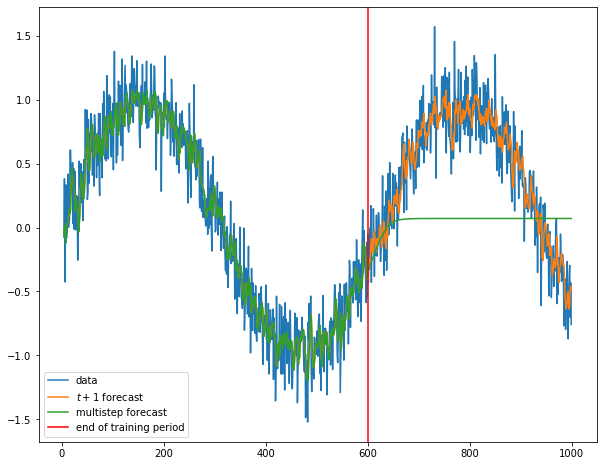

In [41]:
plt.plot(time[tau:], x[tau:], label='data');
plt.plot(time[tau:], yhat_all, label='$t+1$ forecast');
plt.plot(time[tau:], predictions, label='multistep forecast');
plt.axvline(x=ntrain, color='red', label='end of training period');
plt.legend();

The plot suggests two conclusions. First, forecasting longer into the future fails miserably.
Second, for some time, the forecast accuracy of the model seems quite ok. To see this, note that right after entering 
the test set window (highlighted by the red vertical line), the model does right in identifying the upward trend of the 
time series. After a couple of days, however, forecasts become rather useless. 
Intuitively, this result makes sense. Not updating our model with actual data and letting it rely on its own forecasts 
for the entire test set of 400 observation points, the model proves unable to capture the movement of the time series 
correctly. To be fair, a forecast horizon of 400 steps is __long__, especially when considering that the model has only 
seen the previous 600 steps. So when appraising the failure of our model in the above example, we would be fair and 
acknowledge that we have set it a very difficult task. 
Let us consider some more reasonable forecast horizons and examine how our model copes with these. Below, we consider 
four horizons of $4, 8, 16, 32$ observation points.

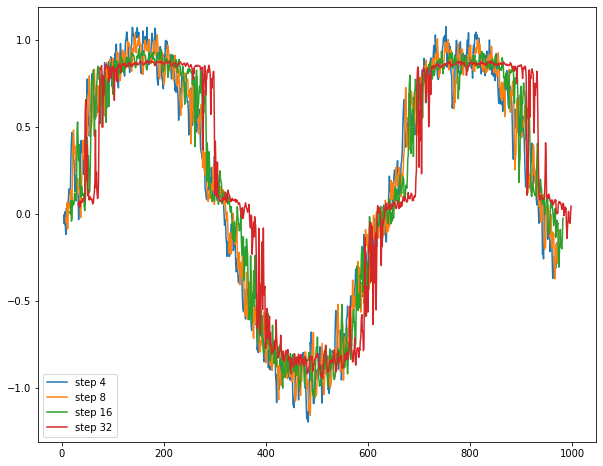

In [42]:
k = 33  # Look up to k - tau steps ahead

# Build the feature matrix: 
# same logic as above but with more (i.e. k) dimensions.
# The loop initializes the first tau elements with actuals
features = np.zeros((T-k, k))
for i in range(tau):
    features[:,i] = x[i:T-k+i]
# fill up remaining elements of the feature matrix with network predictions
for i in range(tau, k):
    features[:,i] = nn.predict(features[:,(i-tau):i]).reshape((-1))

# plot results
for i in (4, 8, 16, 32):
    plt.plot(time[i:T-k+i], features[:,i],
             label=('step ' + str(i)))
plt.legend();